In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os
import opendatasets as od
import csv
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import seaborn as sns
import noisereduce as nr
from IPython.display import Audio
import librosa
import librosa.display
import wave
from numba import jit, cuda 
import torch

import scipy.stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, StratifiedKFold, train_test_split

import prjLib as lib

import warnings
warnings.filterwarnings ('ignore')

## Grid Search

Prediction Train Accuracy: 99.97 %
Prediction Test Accuracy: 61.73 %
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       363
           1       0.54      0.51      0.52       330
           2       0.60      0.64      0.62       405
           3       0.68      0.80      0.73       447
           4       0.69      0.44      0.54       391
           5       0.52      0.52      0.52       379
           6       0.91      0.80      0.85       118

    accuracy                           0.62      2433
   macro avg       0.65      0.63      0.63      2433
weighted avg       0.62      0.62      0.61      2433



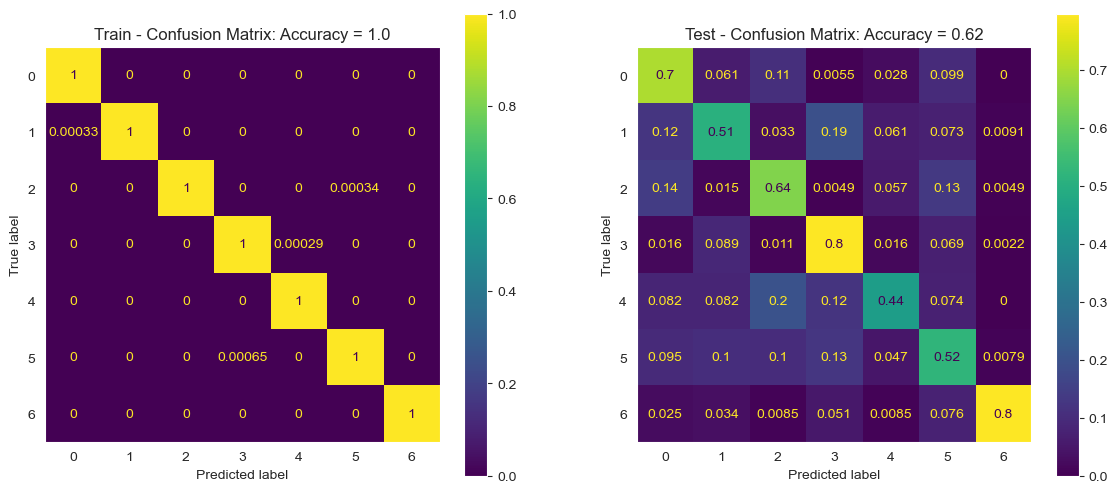

In [2]:
# load data from files
train_features_selected = lib.LoadCsv('train_features_selected')
train_labels = lib.LoadCsv('train_labels')
test_features_selected = lib.LoadCsv('test_features_selected')
test_labels = lib.LoadCsv('test_labels')

# Test selected features
report, score, model = lib.TestClassificationModel(train_features_selected,train_labels,test_features_selected,test_labels,3, paramC=1,kernelType='rbf',n_estimators=100,min_samples_split=6,random_state=1, plot=True)

In [3]:
def CrossValidation(model,numFold):
    trainAccArr = cross_val_score(
        model, 
        train_features_selected, 
        train_labels, 
        cv = StratifiedKFold(numFold, shuffle = True),
        n_jobs=-1)
    trainAcc = np.mean(trainAccArr)
    return trainAcc

def TestBestModel(model):
    model.fit(train_features_selected,train_labels)
    train_labels_pred = model.predict(train_features_selected)
    train_accuracy = model.score(train_features_selected,train_labels)
    test_labels_pred = model.predict(test_features_selected)
    test_accuracy = model.score(test_features_selected,test_labels)
    report = classification_report(test_labels,test_labels_pred)
    print(f'Prediction Train Accuracy: {train_accuracy*100:3.2f} %')
    print(f'Prediction Test Accuracy: {test_accuracy*100:3.2f} %')
    print(f'{report}')
    plt.figure(figsize=(14, 6))
    ax = plt.subplot(1,2,1)
    lConfMatTrainData = {'vY': train_labels, 'vYPred': train_labels_pred, 'hA': ax, 'dScore': {'Accuracy': train_accuracy}, 'titleStr': 'Train - Confusion Matrix'}
    lib.PlotConfusionMatrix(**lConfMatTrainData)
    ax = plt.subplot(1,2,2)
    lConfMatTestData = {'vY': test_labels, 'vYPred': test_labels_pred, 'hA': ax, 'dScore': {'Accuracy': test_accuracy}, 'titleStr': 'Test - Confusion Matrix'}
    lib.PlotConfusionMatrix(**lConfMatTestData)
    plt.show()

### XGBoost

In [4]:
from xgboost import XGBClassifier

study_name="Search_XGBoost_1"
study_XGBoost = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_name}.db",  # Specify the storage URL here.
    direction='maximize'
)

def oSearch_XGBoost(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    numFold = trial.suggest_int("numFold", 10, 20)
    trainAcc = CrossValidation(XGBClassifier(n_estimators=n_estimators,random_state=1,n_jobs=-1),numFold)
    return trainAcc

[I 2024-05-04 13:51:50,516] A new study created in RDB with name: Search_XGBoost_1


In [5]:
study_XGBoost.optimize(oSearch_XGBoost, n_trials=100)
print(f"Best score: {study_XGBoost.best_value}, Best Params: {study_XGBoost.best_params}")

# Test best model
TestBestModel(XGBClassifier(n_estimators=study_XGBoost.best_params['n_estimators'],random_state=1,n_jobs=-1))